# A continuation of our class notebook...

Used the "add data" functionality to connect this notebook to the GloVe embeddings, which allows us to get past the issue we had in class!

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current sessiona

/kaggle/input/glove6b50dtxt/glove.6B.50d.txt
/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


In [19]:
# Other Inputs
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords

import re
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers

In [17]:
# Defining our results visualization function
def visualize_training_results(history):
    '''
    From https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    
    Input: keras history object (output from trained model)
    '''
    fig, (ax1, ax2) = plt.subplots(2, sharex=True)
    fig.suptitle('Model Results')

    # summarize history for accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_ylabel('Accuracy')
    ax1.legend(['train', 'test'], loc='upper left')
    # summarize history for loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_ylabel('Loss')
    ax2.legend(['train', 'test'], loc='upper left')
    
    plt.xlabel('Epoch')
    plt.show()

In [4]:
# Read in data
df = pd.read_csv('../input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
# Check our version number - hopefully this will solve the issue
np.__version__

'1.19.5'

In [6]:
# Preprocess reviews
stop_words = stopwords.words('english')

df['review'] = df['review'].apply(lambda x:  re.sub(r'<[^>]*>', '', x))
df['review'] = df['review'].apply(lambda x: ' '.join(
    [word for word in x.split() if word.lower() not in (stop_words)]))

In [7]:
# Preprocess our target
target_map = {'positive': 1,
              'negative': 0}

df['sentiment'] = df['sentiment'].map(target_map)

In [8]:
# Define our X and y
X = df['review']
y = df['sentiment']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [9]:
# Find our longest review for padding later
max_length = max([len(s.split()) for s in X_train])
max_length

1452

In [10]:
# Tokenize our text
tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [11]:
# Find our vocab_size to use as a param later
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

110202


In [12]:
# Padding our inputs so they're all the same length
X_train = keras.preprocessing.sequence.pad_sequences(
    X_train, maxlen=max_length, padding='post')
X_test = keras.preprocessing.sequence.pad_sequences(
    X_test, maxlen=max_length, padding='post')

In [13]:
def create_embedding_matrix(glove_filepath, word_index, embedding_dim):
    '''
    Function from https://realpython.com/python-keras-text-classification/#using-pretrained-word-embeddings
    Grabs the embeddings just for the words in our vocabulary
    
    Inputs:
    glove_filepath - string, location of the glove text file to use
    word_index - word_index attribute from the keras tokenizer
    embedding_dim - int, number of dimensions to embed, a hyperparameter
    
    Output:
    embedding_matrix - numpy array of embeddings
    '''
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(glove_filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [14]:
embedding_dim = 50
embedding_matrix = create_embedding_matrix('../input/glove6b50dtxt/glove.6B.50d.txt',
                                           tokenizer.word_index, 
                                           embedding_dim)

In [21]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [26]:
model = keras.models.Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim,
                           weights=[embedding_matrix],
                           input_length=max_length,
                           trainable=True))
# Changing our previous simple dense layer to an LSTM
# Adding some dropout to prevent overfitting 
model.add(layers.LSTM(embedding_dim, 
                      dropout=0.2,
                      return_sequences=False))

model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1452, 50)          5510100   
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 5,530,351
Trainable params: 5,530,351
Non-trainable params: 0
_________________________________________________________________


In [27]:
history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=100,
                    validation_data=(X_test, y_test),
                    callbacks=es)
# This takes a decent amount of time if you don't enable Kaggle's GPUs to train on

Epoch 1/100
375/375 [==============================] - 51s 131ms/step - loss: 0.6932 - accuracy: 0.5016 - val_loss: 0.6931 - val_accuracy: 0.5074
Epoch 2/100
375/375 [==============================] - 48s 128ms/step - loss: 0.6932 - accuracy: 0.4972 - val_loss: 0.6932 - val_accuracy: 0.4926
Epoch 3/100
375/375 [==============================] - 48s 129ms/step - loss: 0.6932 - accuracy: 0.4978 - val_loss: 0.6934 - val_accuracy: 0.4926
Epoch 4/100
375/375 [==============================] - 48s 128ms/step - loss: 0.6932 - accuracy: 0.4980 - val_loss: 0.6933 - val_accuracy: 0.4926
Epoch 5/100
375/375 [==============================] - 48s 129ms/step - loss: 0.6931 - accuracy: 0.5033 - val_loss: 0.6931 - val_accuracy: 0.5074
Epoch 6/100
375/375 [==============================] - 48s 128ms/step - loss: 0.6932 - accuracy: 0.5011 - val_loss: 0.6932 - val_accuracy: 0.4926
Epoch 7/100
375/375 [==============================] - 48s 129ms/step - loss: 0.6931 - accuracy: 0.5027 - val_loss: 0.6933 -

Test loss: 0.6932334899902344
Test accuracy: 0.4925599992275238


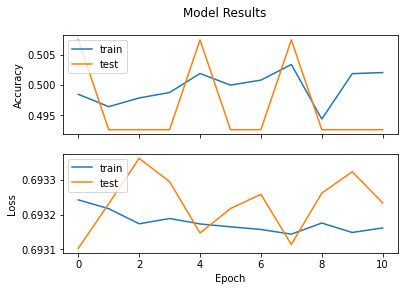

In [28]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

# Visualize results
visualize_training_results(history)

Not great! Probably needs more layers! But remember, more layers = more time to train